# Tutorial: Epidemiology Models


## Advanced Macroeconomics: Numerical Methods  (MIE37)



H.W. Heathcote: epidemiologic models are *deterministic models for infectious diseases which are spread by direct person-to-person contact in a population*.

This kind of models has been used since by a few decades by economist, for matters that have nothing to do with health.

- diffusion of information, or opinions on social medias
- asset prices and fads
- expectation formation for macroeconomic outcomes (ex: *The Epidemiology of Macroeconomic Expectations* by Chris Carroll)

Epidemiologic models have two features that depart from standard economic models:

- Agent's behaviour does not take the full system into account, an is irrational in the sense that it isn't forwards looking. Instead, an agent is given a behavioural heuristic.
- The transitions of the whole system can be determined without solving for complex interactions first.

Understanding why these two assumptions are very costly for economists will keep us busy during a big part of the course. Here we just consider two simple models as small programming exercises.

### Simple SIR model

There is a continuum of agents of mass $1$. Each agent can be either "Susceptible" (S), "Infected" (I) or "Recovered" (R).
In each period, one agent meets another agent drawn randomly.
During a meeting Susceptible agents who meet an infected agent, will always catch the disease (or the fad) but are not contagious. Infected agents, have a probability $\pi$ of being recovered. Nothing happens to Recovered agents who meet other people. No distinction is made between recovering as a healthy or a dead person.

We're interested in the evolution in the number infected persons, both the speed of infection and the total amount of infected people in every period.

__Write down the transition equations for $n_I$, the number of infected people, for $n_R$ the number of recovered people and $n_S$ the number of susceptible people.__



$$n_{s,t+1} = n_{s,t} - \underbrace{ n_{s,t}*n_{i,t}}_{\text{newly infected}}$$

$$n_{i,t+1} = i_{i,t} +  n_{s,t}*n_{i,t} - π i_{i,t}$$

$$n_{r,t+1} = n_{r,t} + π i_{i,t}$$

__Compute the transition function `f` for the vector state $s_t$ returning $s_{t+1}$.__



In [1]:
s0 = [0.9, 0.1, 0.0]

3-element Vector{Float64}:
 0.9
 0.1
 0.0

In [4]:
function f(s; π=0.05)

    n_S, n_I, n_R = s

    nn_S = n_S - n_S*n_I
    nn_I = n_I + n_S*n_I - π*n_I
    nn_R = n_R + π*(n_I)

    return [nn_S, nn_I, nn_R]

end

f (generic function with 1 method)

In [5]:
f(s0)

3-element Vector{Float64}:
 0.81
 0.185
 0.005000000000000001

__Compute the transitions over $T$ periods. Plot the result using Plots.jl. (bonus: check against closed form solution)__



In [38]:
function simulate(s0; π=0.05, T=100)

    sim = [] # here the object is of type Vector{Any}
    # sim = Vector{Float64}[] # here the object is of type Vector{Any}
    
    for t=1:T
        # push!(sim, (s0))
        push!(sim, (;S=s0[1], I=s0[2], R=s0[3] ))
        s1 = f(s0;π=π)
        s0 = s1
    end

    sim

end    

simulate (generic function with 1 method)

In [39]:
@time sim = simulate(s0; T=100);

  0.031591 seconds (26.58 k allocations: 1.418 MiB, 99.90% compilation time)


In [40]:
# @benchmark sim = simulate(s0; T=100000);

In [41]:
typeof(sim)

Vector{Any} (alias for Array{Any, 1})

In [42]:
using Plots

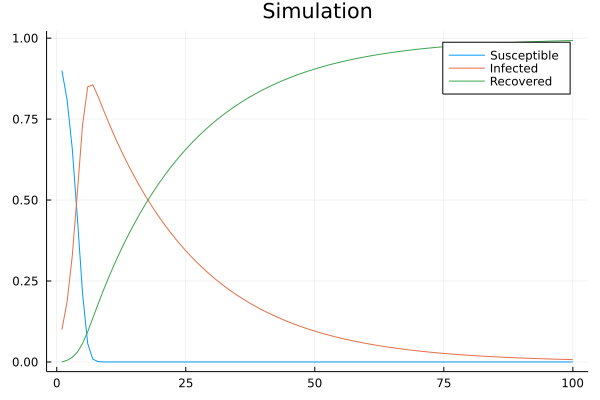

In [43]:
pl = plot(title="Simulation")
plot!(pl, [e[1] for e in sim]; label="Susceptible")
plot!(pl, [e[2] for e in sim]; label="Infected")
plot!(pl, [e[3] for e in sim]; label="Recovered")
pl



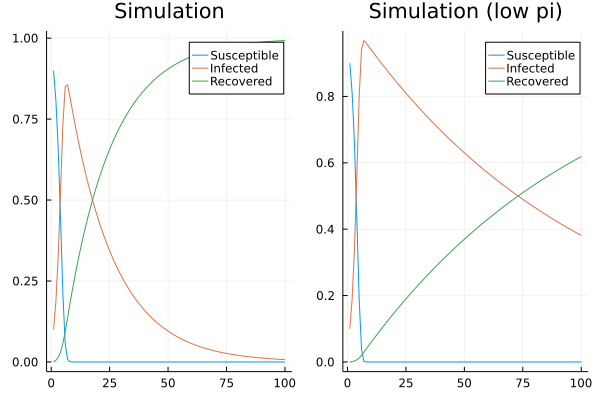

In [47]:
sim = simulate(s0; T=100);
sim2 = simulate(s0; T=100, π=0.01);

pl = plot(title="Simulation")
plot!(pl, [e.S for e in sim]; label="Susceptible")
plot!(pl, [e.I for e in sim]; label="Infected")
plot!(pl, [e.R for e in sim]; label="Recovered")


pl2 = plot(title="Simulation (low pi)")
plot!(pl2, [e.S for e in sim2]; label="Susceptible")
plot!(pl2, [e.I for e in sim2]; label="Infected")
plot!(pl2, [e.R for e in sim2]; label="Recovered")
pl2

plot(pl, pl2)

__We now assume a Susceptible person who meets an infected one has a probability $\mu$ of catching the disease. Update the transition function. Update function $f$ and write a function of $\mu$, $\pi$ which returns the simulation. Compare different values of the parameters. How would you interpret "social distancing"? How would you choose parameters $\Pi$ and $\mu$__ 

### A Spatial SIR model

We now consider another version of the model where agents evolve in the space $\mathcal{S}=[0,1]\times[0,1]$. There are $N\in\mathbb{N}$ agent. At any date, each agent $n \in [0,1]$  is located at $(x_n,y_n)\in \mathcal{S}$.

Each agent moves follows a random walk bounded by $\mathcal{S}$:
$$x_t = \min(\max( x_{t-1} + \epsilon_t, 0), 1)$$
$$y_t = \min(\max( y_{t-1} + \eta_t, 0), 1)$$
where $\epsilon_t$ and $\eta_t$ are both normally distributed with standard deviation $\sigma$.

At any date, the individual state of an agent is $s_t=(x_t, y_t, h_t)$ where $h_t$ is either "S", "I" or "R". $v_t$ denotes the states of all agents (for instance $v_t=(s_{n,t})_n$. The health status of each agent is updated in the following way:

- Agents $R$  stay $R$.
- Agents $I$ have probability $\pi$ to become $R$. They stay $I$ otherwise.
- An agent of type $S$ in position $(x,y)$ has a probability $prob(x,y,S)$ to be infected that is $\mu$ if there is another infected agent within a radius $r>0$.


__Define a type `Agent`, which holds the type of an agent. The state of the whole system will be held in a `Vector[Agent]` type.__



In [1]:
struct Status
    state::Int8
end

struct Agent
    x::Float64
    y::Float64
    status::Status
end

struct Parameters
    π::Float64
    μ::Float64
    σ::Float64
    r::Float64
end

In [2]:
p0 = Parameters(0.1, 0.1, 0.001, 0.1)

Parameters(0.1, 0.1, 0.001, 0.1)

In [3]:
rand() # uniform between 0 and 1

0.9645133907543597

In [4]:
const SUSCEPTIBLE = Status(0)
const INFECTED = Status(1)
const RECOVERED = Status(2)

Status(2)

In [5]:
Agent(0.4, 0.2, INFECTED)

Agent(0.4, 0.2, Status(1))

In [6]:
Agent() = Agent(rand(), rand(), SUSCEPTIBLE)

Agent

In [8]:
import Base: rand

In [9]:
rand(::Type{Agent}) = Agent()

rand (generic function with 82 methods)

In [10]:
rand(Agent)

Agent(0.12241393063082096, 0.009820745516522678, Status(0))

In [11]:
Agent()

Agent(0.04704558826258931, 0.5582242718714534, Status(0))

In [12]:
N = 100

100

In [13]:
population = [Agent() for i=1:N]

100-element Vector{Agent}:
 Agent(0.603474617660857, 0.04984181483460226, Status(0))
 Agent(0.5692517542408487, 0.4968235776556129, Status(0))
 Agent(0.8801593677800986, 0.21082627297869572, Status(0))
 Agent(0.6890219567821928, 0.7889357942851952, Status(0))
 Agent(0.7626365464770398, 0.6843585685767309, Status(0))
 Agent(0.608943597583597, 0.5003788557044796, Status(0))
 Agent(0.790167128396794, 0.35324161731764236, Status(0))
 Agent(0.10574309961267592, 0.13035959478004067, Status(0))
 Agent(0.639248323010488, 0.9310489780139874, Status(0))
 Agent(0.7975770467075609, 0.7176061106024042, Status(0))
 ⋮
 Agent(0.9086189632277857, 0.6411997710867648, Status(0))
 Agent(0.7629250832195819, 0.4149410225883555, Status(0))
 Agent(0.7684816918347468, 0.5317898079648127, Status(0))
 Agent(0.919114830226366, 0.27304980482411334, Status(0))
 Agent(0.8519677622187019, 0.4869021633645947, Status(0))
 Agent(0.11136045666318939, 0.6830924155620919, Status(0))
 Agent(0.8571207724822775, 0.94393032346

__Write a function `spatial_transition(S::Vector{Agent})::Vector{Agent}` to compute the transition of the positions. Write another function `random_guess(T=100)` which simulates for $T$ periods in order to find a good initial guess.__



In [16]:
function move(agent::Agent, p::Parameters)
    x = agent.x + randn()*p.σ
    y = agent.y + randn()*p.σ
    return Agent(x, y, agent.status)
end

move (generic function with 1 method)

In [17]:
s = Agent()

Agent(0.19109302144457063, 0.9972375327137523, Status(0))

In [18]:
move(s, p0)

Agent(0.19140459573580712, 0.9985560158311684, Status(0))

In [19]:
function spatial_transition(S::Vector{Agent}, p::Parameters)
    out = [move(agent, p) for agent in S]
    return out
end

spatial_transition (generic function with 1 method)

In [21]:
spatial_transition(population, p0);

In [22]:
function random_guess(p0, T=100, N=100)
    population = [Agent() for n =1:N]
    for t in 1:T
        population = spatial_transition(population, p0)
    end
    return population
    
end

random_guess (generic function with 3 methods)

In [23]:
random_guess(p0)

100-element Vector{Agent}:
 Agent(0.2976064486608136, 0.5784539646390013, Status(0))
 Agent(0.29763083333041257, 0.8425679924681841, Status(0))
 Agent(0.8916400971653442, 0.194460738386959, Status(0))
 Agent(0.4078025879854576, 1.0026092982646875, Status(0))
 Agent(0.8222643728515747, 0.8635643003337271, Status(0))
 Agent(0.557986697251115, 0.05677355700380427, Status(0))
 Agent(0.624994363104445, 0.8058887201857622, Status(0))
 Agent(0.9639917981338069, 0.03198111152540351, Status(0))
 Agent(0.26875685736220184, 0.23757018739610938, Status(0))
 Agent(0.5312074608062188, 0.9901156821302931, Status(0))
 ⋮
 Agent(0.7637196750232844, 0.2324507593082516, Status(0))
 Agent(0.6140989842838054, 0.49153521124236615, Status(0))
 Agent(0.12728164966963984, 0.7609489635537258, Status(0))
 Agent(0.9063144322011756, 0.2738246510859142, Status(0))
 Agent(0.9759053788780547, 0.8184258196689864, Status(0))
 Agent(0.3001853299414538, 0.21435262826928347, Status(0))
 Agent(0.3041065562385744, 0.05225009

__Write a function `show_population` to plot all agents with different colors for different health status.__



In [25]:
import Plots: plot, plot!

In [26]:
using Plots # imports all functions that are "exported"

┌ Warning: Skipped marker arg ..
└ @ Plots /home/pablo/.julia/packages/Plots/FCUr0/src/args.jl:1224


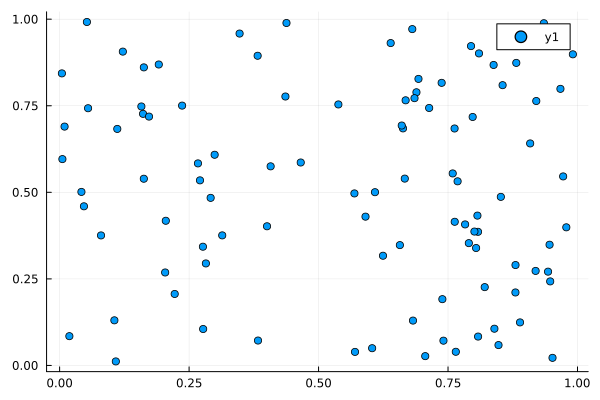

In [28]:
plot(
 [a.x for a in population],
 [a.y for a in population];
 marker=".", seriestype=:scatter # should make lines invisible
)

┌ Warning: Skipped marker arg ..
└ @ Plots /home/pablo/.julia/packages/Plots/8K4be/src/args.jl:1230


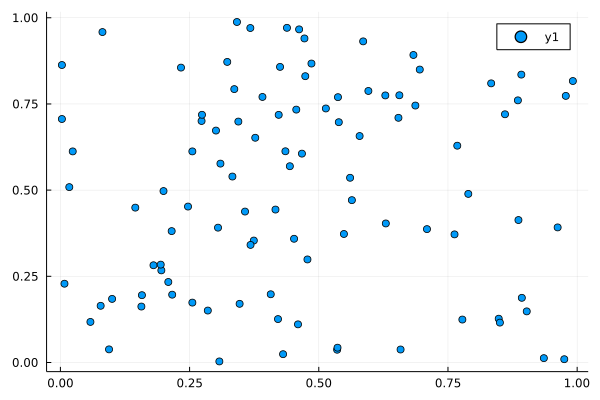

In [21]:
scatter(
[a.x for a in population],
[a.y for a in population]; marker=".", seriestype=:scatter # should make lines invisible
)

In [22]:
import Plots: plot

In [33]:
function plot(population::Vector{Agent})
    pl = scatter(
        [a.x for a in population],
        [a.y for a in population]; marker=".", seriestype=:scatter # should make lines invisible
    )
    return pl
end

plot (generic function with 5 methods)

In [34]:
pop0 = random_guess(p0);

┌ Warning: Skipped marker arg ..
└ @ Plots /home/pablo/.julia/packages/Plots/FCUr0/src/args.jl:1224
┌ Warning: Skipped marker arg ..
└ @ Plots /home/pablo/.julia/packages/Plots/FCUr0/src/args.jl:1224


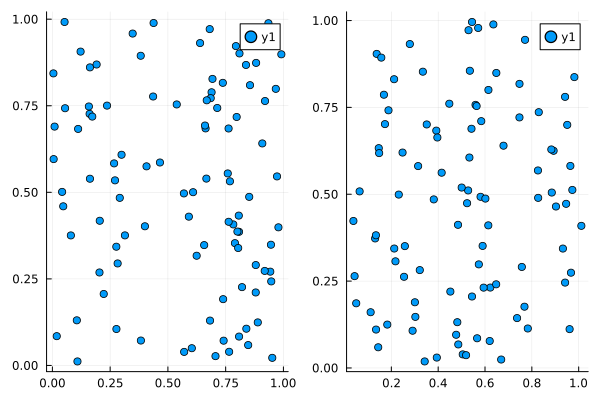

In [39]:
pl1 = plot(population)
pl2 = plot(pop0)
plot(pl1, pl2)

__Write a function `evolve(S::Vector[Agent])::Vector[Agent]` which takes the population in a given state and returns the same population with updated health status.__



In [40]:
import Base: -
(-)(a1, a2) = Agent( a1.x-a2.x, a1.y - a2.y, a1.status)

- (generic function with 277 methods)

In [42]:
function distance(a1::Agent, a2::Agent) 
    d = a2-a1
    sqrt( ((d).x)^2 + ((d).y)^2 )
end

distance (generic function with 1 method)

In [43]:
distance(a1::Agent, a2::Agent) = begin d = a2-a1; sqrt( ((a2-a1).x)^2 + ((a2-a1).y)^2 ) end

distance (generic function with 1 method)

In [44]:
distance(Agent(), Agent())

0.7510463976312519

In [50]:
function evolve(S::Vector{Agent}, p::Parameters)
    S = spatial_transition(S, p)
    new_S = []
    for (agent) in (S)
        if agent.status == SUSCEPTIBLE
            
            risky_encounter = false
            for (oagent) in (S)
                    d = distance(agent, oagent)
                    if (d<p.r) && (oagent.status == INFECTED)
                        risky_encounter=true
                        break
                    end
                break
            end
            
            if risky_encounter
                if rand() < p.μ
                    new_agent = Agent(agent.x, agent.y, INFECTED)
                else
                    new_agent = agent
                end
            else
                new_agent = agent
            end
            
            
        elseif agent.status == INFECTED
            if rand() < p.π
                new_agent = Agent(agent.x, agent.y, RECOVERED)
            else
                new_agent = agent
            end
        elseif agent.status == RECOVERED
            new_agent = agent
        end
        
        push!(new_S, new_agent)
        
    end
    
    return new_S
    
end

evolve (generic function with 1 method)

In [51]:
infect(agent::Agent) = Agent(agent.x, agent.y, INFECTED)

infect (generic function with 1 method)

In [52]:
pop0[1] = infect(pop0[1])

Agent(0.14398902534673688, 0.05952932502871551, Status(1))

In [53]:
evolve(pop0, p0)

100-element Vector{Any}:
 Agent(0.14443591008212647, 0.05973319651057636, Status(1))
 Agent(0.21391446312298745, 0.3431716231916697, Status(0))
 Agent(0.1313821247762785, 0.3733738724607018, Status(0))
 Agent(0.829487554150509, 0.7374014404077809, Status(0))
 Agent(0.18258910706447048, 0.12465025380744699, Status(0))
 Agent(0.33550908262118523, 0.8518606650608103, Status(0))
 Agent(0.06379645488594773, 0.508292158862834, Status(0))
 Agent(0.8275029549746096, 0.4894650328908453, Status(0))
 Agent(0.9619221744912682, 0.5823744241196236, Status(0))
 Agent(0.21757943870229296, 0.3058418297798114, Status(0))
 ⋮
 Agent(0.534384102884382, 0.8559941465050988, Status(0))
 Agent(0.3042231405607041, 0.14661669046195813, Status(0))
 Agent(0.76966652918973, 0.17548740727096868, Status(0))
 Agent(0.28041408456733286, 0.9318658472895824, Status(0))
 Agent(0.11113123658314303, 0.1586064285347957, Status(0))
 Agent(0.5643325416237239, 0.7518932089796421, Status(0))
 Agent(0.5406388076341186, 0.68803351

__Write a function `simulate(S0::Vector[Agent], k=1)` to simulate the economy starting from an initially random position with `k` infected individuals. The returned object should be of type `Vector[Vector[Agent]]`.__



In [54]:
function simulate(S0::Vector{Agent}, p::Parameters; T=1)
    sim = [S0]
    for t=1:T
        pop = sim[end]
        push!(sim, evolve(pop, p))
    end
    return sim
end

simulate (generic function with 1 method)

In [55]:
sim = simulate(pop0, p0; T=100)

101-element Vector{Vector{Agent}}:
 [Agent(0.14398902534673688, 0.05952932502871551, Status(1)), Agent(0.2124018391497947, 0.3437524458344835, Status(0)), Agent(0.13086677181219225, 0.37280223522340816, Status(0)), Agent(0.8295148524188453, 0.7362148104558279, Status(0)), Agent(0.1827213766460102, 0.1248206543010004, Status(0)), Agent(0.3346321547696226, 0.852755785564367, Status(0)), Agent(0.06454574623725366, 0.5082540848095396, Status(0)), Agent(0.8270333722715933, 0.4896086495976404, Status(0)), Agent(0.9645119025258528, 0.5815205247675457, Status(0)), Agent(0.21759580890339664, 0.3069491282927926, Status(0))  …  Agent(0.32145427162414997, 0.28167912709610876, Status(0)), Agent(0.5353041230108323, 0.8554402985083074, Status(0)), Agent(0.3025957760944855, 0.14703134881851318, Status(0)), Agent(0.7685323119924398, 0.17632622180897486, Status(0)), Agent(0.2789629280164711, 0.9323492115020356, Status(0)), Agent(0.11163520540275197, 0.16042197379821738, Status(0)), Agent(0.5640745835346

__Compute statistics along a simulated path for $n_I$, $n_S$, $n_R$. Plot and compare with the basic SIR model__

In [56]:
count(pop::Vector{Agent}, state) = sum(a.status==state for a in pop)

count (generic function with 1 method)

In [57]:
count(pop0, SUSCEPTIBLE)
count(pop0, SUSCEPTIBLE)

99

In [58]:
p0.

ErrorException: syntax: incomplete: premature end of input

In [71]:
Parameters( )

Parameters

In [90]:
p0 = Parameters(0.5, 0.5, 0.1, 0.5)



Parameters(0.5, 0.5, 0.1, 0.5)

In [91]:

pop0 = [(  i<500 ? Agent() : Agent(rand(), rand(),INFECTED))  for i=1:1000]

1000-element Vector{Agent}:
 Agent(0.34601881483822994, 0.4833601843652213, Status(0))
 Agent(0.31871272453786015, 0.5227179829696845, Status(0))
 Agent(0.40497775771527744, 0.42728672976027526, Status(0))
 Agent(0.39281924909063404, 0.5462989133830746, Status(0))
 Agent(0.8791346554511515, 0.07112433718776112, Status(0))
 Agent(0.33821912271807497, 0.6530759309596189, Status(0))
 Agent(0.02011787161960521, 0.9245434941230084, Status(0))
 Agent(0.06917495257137729, 0.8086018393407772, Status(0))
 Agent(0.5168215737273881, 0.9527479765632932, Status(0))
 Agent(0.7172381447406931, 0.4684780188160621, Status(0))
 ⋮
 Agent(0.7673487108840666, 0.7760552875935144, Status(1))
 Agent(0.5612292591999373, 0.16270509894676477, Status(1))
 Agent(0.166345546162893, 0.9702601622966601, Status(1))
 Agent(0.46495756132573607, 0.36372401842244917, Status(1))
 Agent(0.9186814802176809, 0.3822277278220495, Status(1))
 Agent(0.4752041344027216, 0.8191230363590178, Status(1))
 Agent(0.6026340900048122, 0.0

In [92]:
sim = simulate(pop0, p0; T=100);

In [93]:
sim_n_S = [count(pop, SUSCEPTIBLE) for pop in sim]
sim_n_I = [count(pop, INFECTED) for pop in sim]
sim_n_R = [count(pop, RECOVERED) for pop in sim]


101-element Vector{Int64}:
   0
 247
 369
 436
 467
 489
 495
 498
 499
 500
   ⋮
 501
 501
 501
 501
 501
 501
 501
 501
 501

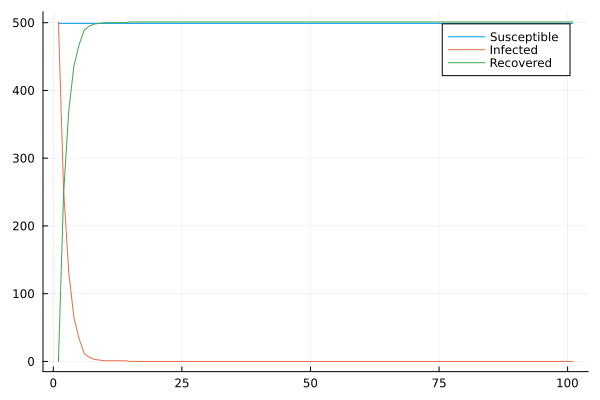

In [94]:
pl = plot(sim_n_S, label="Susceptible")
plot!(pl, sim_n_I, label="Infected")
plot!(pl, sim_n_R, label="Recovered")


### Additional questions

Have fun by trying to answer one of these questions:
- change probability of infection so that it depends on the number of infected people in the vincinity (with some suitable functional formulation for)
- compute an animation of the transition
- compute an interactive visualisation (with `Interact.jl` if available)